# Figure 4

In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

In [2]:
from classes import *
import copy
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import pickle

import tqdm


from models import Rotty
from mayors import *

### Load the model with parameters

In [3]:
#global pars (for the development of Trust) Will be removed 
k = 0.2 
T_eq = 70
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(1, ['Major flood', 40]), (0, ['Small flood', 20]), (-0.2, ['Near miss', 10]), (-0.4, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])]), 'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}, 'I_social': 1}

### Load storm surge scenarios

In [4]:
# Load all SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(Path('..','SLR_projections','Transients'))

# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in Path('..','SurgeHeight','biased_from_five_hundred').glob('*.csv'):
    obj = SurgeHeight(filename.stem) #Init object with name derived from filename
    obj.from_csv(filename) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)
        
# Print all available SLR scenarios
for SLR_Scenario in allSLR_Scenario:
    print(SLR_Scenario.name,end=' ||| ')

Scenario_01 ||| Scenario_02 ||| Scenario_03 ||| Scenario_04 ||| Scenario_05 ||| Scenario_06 ||| Scenario_07 ||| Scenario_08 ||| Scenario_09 ||| 

### Run this block if you want to focus on a subset of the scenarios

In [5]:
# Make a manual preselection of scenarios to simplify plots
storm_surges = ["five_hundred_8","five_hundred_10"]
selection = [x for x in allSurgeLevel if x.name.split("__")[1] in storm_surges] #only run experiments for one of the transients
#selection = allSurgeLevel
selected_slr = ['03','06']
#selection = [x for x in selection if x.name.split('__')[0] in ['SROCC_2019_RCP26_17','SROCC_2019_RCP85_50','SROCC_2019_RCP85_83','Bamber_2019_high_95']]
selection =  [x for x in selection if x.name.split('__')[0].split('_')[1] in selected_slr]
len(selection)

4

### Load adaptation strategies (Mayors)

In [6]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Select implementation times of measures

In [7]:
Implementation_times = [ #small measure, large measure
    (4,6),
    (5,7),
    (6,9), 
    (7,10), #default
    (8,11),
    (9,13),
    (10,14),
    (11,16),
    (12,17),
    (13,19),
    (14,20)]

In [8]:
it_sel = 5 #select the it_pairs from the list

### Model run algorithm

In [9]:
from run_model import run_model01

### Run the model for the combinations of Mayors, SLR Scenarios and storm surge sceanrios

In [10]:
#run one mayor:
experiments = []
for SurgeLevel in selection:
    for Mayor in allMayors:
        experiment = run_model01(Rotty,SurgeLevel,Mayor,Implementation_times[it_sel],do_print=True)
        experiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Scenario_03__five_hundred_10_R. Active_(9, 13) 2021/01/21, 17:47:14
Finished experiment Rotty_Scenario_03__five_hundred_10_H. Economicus_(9, 13) 2021/01/21, 17:47:15
Finished experiment Rotty_Scenario_03__five_hundred_10_Sentiment_(9, 13) 2021/01/21, 17:47:15
Finished experiment Rotty_Scenario_03__five_hundred_10_Lawkeeper_(9, 13) 2021/01/21, 17:47:15
Finished experiment Rotty_Scenario_03__five_hundred_8_R. Active_(9, 13) 2021/01/21, 17:47:16
Finished experiment Rotty_Scenario_03__five_hundred_8_H. Economicus_(9, 13) 2021/01/21, 17:47:16
Finished experiment Rotty_Scenario_03__five_hundred_8_Sentiment_(9, 13) 2021/01/21, 17:47:16
Finished experiment Rotty_Scenario_03__five_hundred_8_Lawkeeper_(9, 13) 2021/01/21, 17:47:16
Finished experiment Rotty_Scenario_06__five_hundred_10_R. Active_(9, 13) 2021/01/21, 17:47:17
Finished experiment Rotty_Scenario_06__five_hundred_10_H. Economicus_(9, 13) 2021/01/21, 17:47:17
Finished experiment Rotty_Scenario_06__five_hundred_

In [11]:
#Further selection to avoid information overload
sel_experiments = [] #only keep selected experiments
for exp in experiments:
    if exp.SurgeLevel.corresponding_SLR_Scenario.name == 'Scenario_03':
        if exp.SurgeLevel.corresponding_SurgeHeight.name == 'five_hundred_10':
            if exp.Mayor.get_name() in ['Sentiment','Lawkeeper']:
                sel_experiments.append(exp)
    
    if exp.SurgeLevel.corresponding_SLR_Scenario.name == 'Scenario_06':
        if exp.SurgeLevel.corresponding_SurgeHeight.name == 'five_hundred_8':
            if exp.Mayor.get_name() in ['R. Active','H. Economicus']:
                sel_experiments.append(exp)
sel_experiments

[Rotty_Scenario_03__five_hundred_10_Sentiment_(9, 13) 2021/01/21, 17:47:15,
 Rotty_Scenario_03__five_hundred_10_Lawkeeper_(9, 13) 2021/01/21, 17:47:15,
 Rotty_Scenario_06__five_hundred_8_R. Active_(9, 13) 2021/01/21, 17:47:18,
 Rotty_Scenario_06__five_hundred_8_H. Economicus_(9, 13) 2021/01/21, 17:47:18]

In [12]:
remap = {'Area_A':'Area A (unembanked)$^{***}$',
         'Area_B':'Area B (embanked)'}

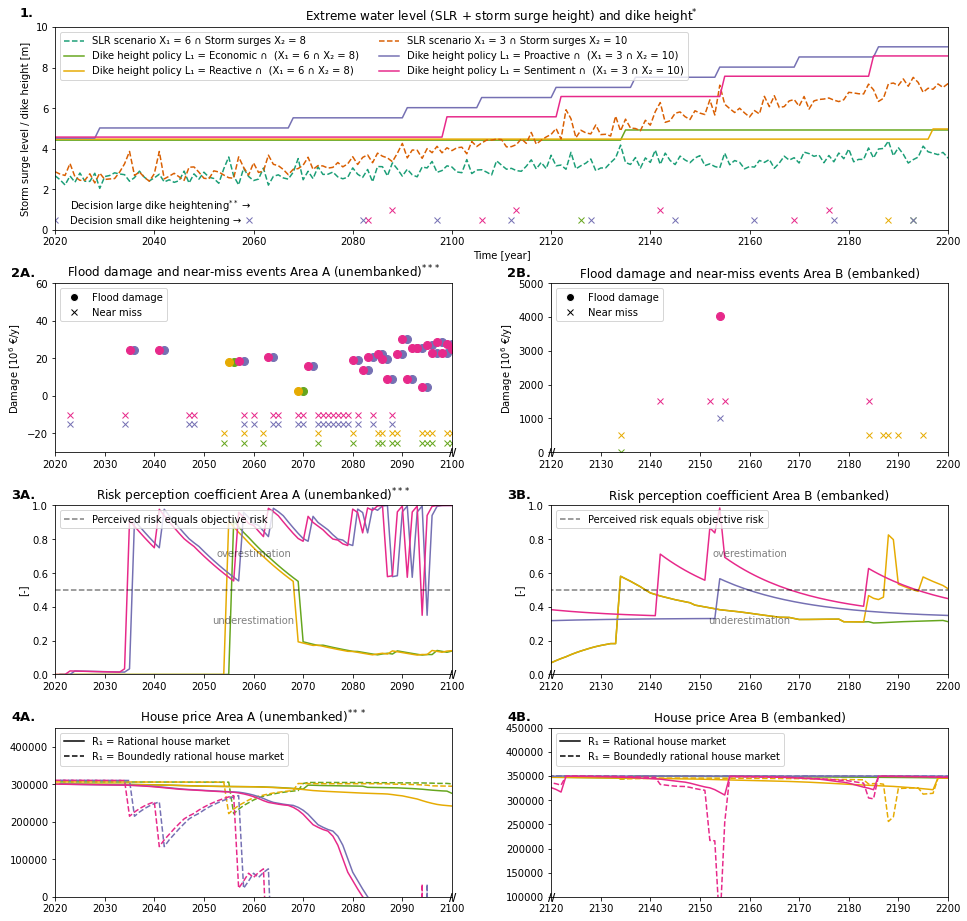

In [25]:
#p1 = ['#e66101','#fdb863','#b2abd2','#5e3c99'] #palette
#p2 = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
#p3 = ['#d7191c','#fdae61','#abdda4','#2b83ba']
#p6 = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']
#p6.reverse()

#p_slr = [p6[1],p6[4]]
#p_mayors = [p6[0],p6[2],p6[3],p6[5]]
#p = p_mayors #voor het gemak

p7 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
p_slr = [p7[0],p7[1]]
p_mayors = [p7[4],p7[5],p7[2],p7[3]]
p = p_mayors #voor het gemak

xlim = (2020,2200)

fig = plt.figure(figsize=(16,16))


nrows=4
ncols=2
hr = [1.2,1,1,1]

grid = plt.GridSpec(nrows=nrows,ncols=ncols, wspace = .25, hspace = .30, figure=fig, height_ratios=hr)

ax00 = fig.add_subplot(grid[0, :])
ax10 = fig.add_subplot(grid[1, 0])
ax11 = fig.add_subplot(grid[1, 1])
ax20 = fig.add_subplot(grid[2, 0])
ax21 = fig.add_subplot(grid[2, 1])
ax30 = fig.add_subplot(grid[3, 0])
ax31 = fig.add_subplot(grid[3, 1])

#mimic the old structure of the axes
axes = [[ax00,ax00],
        [ax10,ax11],
        [ax20,ax21],
        [ax30,ax31]]

handles00 = []


#handles00.append(Line2D([0], [0], color=p_slr[1], label='SLR scenario 06',linestyle='-'))

for j,experiment in enumerate(reversed(sel_experiments)):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    time = SurgeLevel.years
    if j%2 == 0:
        labelSLR = SurgeLevel.corresponding_SLR_Scenario.name.split('_')[1][-1]
        labelSH = SurgeLevel.corresponding_SurgeHeight.name.split('_')[-1]
        label = 'SLR scenario X{} = '.format(u'\u2081') + labelSLR + ' {} Storm surges X{} = '.format(u"\u2229",u'\u2082') + labelSH
        handles00.append(Line2D([0], [0], color=p_slr[j//2], label=label,linestyle='--'))
        ax00.plot(time,SurgeLevel.surgelevel,color=p_slr[j//2],linestyle='--')
    
    ax00.set_title('Extreme water level (SLR + storm surge height) and dike height$^{*}$')
    ax00.set_xlabel('Time [year]')
    ax00.set_ylabel('Storm surge level / dike height [m]')
    ax00.set_ylim(0,10)
    ax00.set_xlim(xlim[0],xlim[1])
    
    y_offset = 0.05
    ax00.plot(time,np.array(Model.allFloodProtection[1].protection_level)-0.075+j*0.05,color=p_mayors[j],linestyle='-')
    
    mh = [m for m in Model.allFloodProtection[1].measure_history]
    mh = [None if m == 0 else m for m in mh]
    ax00.plot(time,mh,'x',color=p_mayors[j]) #PLOT THE HISTORY OF THE MEASURES
    

    
    label = 'Dike height policy L{} = '.format(u'\u2081') + Mayor.paper_name() + ' {} '.format(u"\u2229") + ' (X{} = '.format(u'\u2081') + labelSLR + ' {} X{} = '.format(u"\u2229",u'\u2082') + labelSH + ')'
    #Manually add legend patches
    handles00.append(Line2D([0], [0], color=p_mayors[j],label=label,linestyle='-'))
    
    for i, Area in enumerate(Model.allResidentialArea):      
        #plot damage
        axes[1][i].set_title('Flood damage and near-miss events {}'.format(remap[Area.name]))
        #Slightly offset values to make it more visible
        offset_x = 0
        offset_y = 0
        if Area.name == 'Area_A' and j%2 == 0: 
            offset_x = 1
            offset_y = 0
        axes[1][i].plot(np.array(time)+offset_x, \
                        np.array([x*10**(-6) for x in Model.allResidentialArea[i].flood_damage])+offset_y,'o',color=p[j],markersize=8)
        axes[1][i].set_ylabel('Damage [10$^6$ \u20ac/y]')
    
        axes[2][i].set_title('Risk perception coefficient {}'.format(remap[Area.name]))
        #Slightly offset values to make it more visible
        offset_x = 0
        if Area.name == 'Area_A' and j%2 == 0: 
            offset_x = 1
        axes[2][i].plot(np.array(time)+offset_x,Model.allResidentialArea[i].risk_perception,'-',color=p[j])
        axes[2][i].set_ylabel('[-]')
        axes[2][i].set_ylim(0,1)

        #Slightly offset values to make it more visible
        offset_x = 0
        if Area.name == 'Area_A' and j%2 == 0: 
            offset_x = 1

        axes[3][i].set_title('House price {}'.format(remap[Area.name]))
        axes[3][i].plot(np.array(time)+offset_x,Area.house_price_t_objective,color=p[j])
        custom_lines = [Line2D([0], [0], color='black',label='R{} = Rational house market'.format(u'\u2081'),linestyle='-'),
                        Line2D([0], [0], color='black',label='R{} = Boundedly rational house market'.format(u'\u2081'),linestyle='--')]
        axes[3][i].legend(handles=custom_lines,loc='upper left')
        
        axes[3][i].plot(np.array(time)+offset_x,Area.house_price_t_subjective,'--',color=p[j])
    
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1][0].set_ylim(-30,60)
    HP = Model.allResidentialArea[0]
    temp = [-25 + 5*j if x=='!' else None for x in HP.event_history]
    axes[1][0].plot(time,temp,'x',color=p[j],markersize=6)
            
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1][1].set_ylim(0,5000)
    CC = Model.allResidentialArea[1]
    temp = [0 + 500*j if x=='!' else None for x in CC.event_history]
    axes[1][1].plot(time,temp,'x',color=p[j],markersize=6)

ax00.text(2023,0.3,'Decision small dike heightening ' + u"\u2192",fontweight='normal')
ax00.text(2023,1,'Decision large dike heightening$^{**}$ ' + u"\u2192",fontweight='normal') 
ax00.legend(handles=handles00,ncol=2)

handles10 = [Line2D([0], [0], marker='o', color='w', label='Flood damage', markerfacecolor='black', markersize=8),
             Line2D([0], [0], marker='x', color='w', label='Near miss', markeredgecolor='black', markersize=6)]
ax10.legend(handles=handles10,loc='upper left')
ax11.legend(handles=handles10,loc='upper left')

ax30.set_ylim(0,4.5e5)
ax31.set_ylim(1e5,4.5e5)
        
for p,row in enumerate(axes):
    if p > 0:
        for q,ax in enumerate(row):
            if q%2 == 0: #area A
                ax.set_xlim(2020,2100)
            else:
                ax.set_xlim(2120,2200)
                
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[2][j].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[2][j].legend(handles=custom_line,loc='upper left')
    axes[2][j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[2][j].transAxes,ha='center')
    axes[2][j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[2][j].transAxes,ha='center')

    
axes[0][0].text(-0.04, 1.1, "{}.".format(1), transform=axes[0][0].transAxes,
                       fontsize=13, fontweight='bold', va='top')

for nr in range(1,nrows):
    for l,letter in enumerate(('A','B')):
        axes[nr][l].text(-0.11, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr][l].transAxes,
                       fontsize=13, fontweight='bold', va='top')

# ADD // to imitate axes break        
for ax in [axes[1][0],axes[2][0],axes[3][0]]:
    ax.text(1-1/150,0-2/100,'//',transform=ax.transAxes,fontweight='bold')
for ax in [axes[1][1],axes[2][1],axes[3][1]]:
    ax.text(0-1/150,0-2/100,'//',transform=ax.transAxes,fontweight='bold')

In [23]:
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################

its = Implementation_times[it_sel]
filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1] + "_it_" + str(its)

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path(date)
if not Path.exists(target): target.mkdir()
else: print("Target folder {} already exists".format(target))

fig.savefig(Path(target, (filename + "2.png")),bbox_inches='tight',dpi=150)

Target folder 2021_1_21 already exists


In [42]:
print(	u"\u2192")

→


In [147]:
3%2

1

In [148]:
5//2

2

### Plot the results